# CS 378 Homework 3: Mitigation and Model Cards (100 pts)
Deadline: 11:59 pm, October 12, 2023

This assignment has four parts. First, you will train a model for predicting the creditworthiness of a given individual using the so-called German credit dataset. Second, you will evaluate the model's fairness. Third, you will implement two strategies for the algorithmic mitigation of fairness issues with your model. Finally, you will write a model card for a model you trained in the first part.



## Part 1: Training a Pytorch model on the German Credit Dataset

We want you to train your model using Pytorch as this gives you the flexibility to experiment with different kinds of loss functions. Here is the code for loading and cleaning up the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Data = pd.read_csv("german_credit_data.csv")
print (Data.columns)
Data.head(10)

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
5,5,35,male,1,free,NaN,NaN,9055,36,education,good
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,7,35,male,3,rent,little,moderate,6948,36,car,good
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,9,28,male,3,own,little,moderate,5234,30,car,bad


In [2]:
Data['Saving accounts'] = Data['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
Data['Saving accounts'] = Data['Saving accounts'].fillna(Data['Saving accounts'].dropna().mean())

Data['Checking account'] = Data['Checking account'].map({"little":0,"moderate":1,"rich":2 });
Data['Checking account'] = Data['Checking account'].fillna(Data['Checking account'].dropna().mean())

Data['Sex'] = Data['Sex'].map({"male":0,"female":1}).astype(float)

Data['Housing'] = Data['Housing'].map({"own":0,"free":1,"rent":2}).astype(float)

Data['Purpose'] = Data['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float)

Data['Risk'] = Data['Risk'].map({"good":0,"bad":1}).astype(float)

''' For Q7-Q11

# List of non-sensitive columns to repair
non_sensitive = ['Age', 'Job', 'Credit amount', 'Duration', 'Purpose']

for column in non_sensitive:
    sorted_data = Data.sort_values(by=column)
    bins = pd.qcut(sorted_data[column], q=10, labels=False, duplicates='drop')
    bin_medians = sorted_data.groupby(bins)[column].transform('median')
    Data[column] = bin_medians

'''

Data.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,0.0,2,0.0,0.456548,0.000000,1169,6,0.0,0.0
1,1,22,1.0,2,0.0,0.000000,1.000000,5951,48,0.0,1.0
2,2,49,0.0,1,0.0,0.000000,0.651815,2096,12,1.0,0.0
3,3,45,0.0,2,1.0,0.000000,0.000000,7882,42,2.0,0.0
4,4,53,0.0,2,1.0,0.000000,0.000000,4870,24,3.0,1.0
5,5,35,0.0,1,1.0,0.456548,0.651815,9055,36,1.0,0.0
6,6,53,0.0,2,0.0,2.000000,0.651815,2835,24,2.0,0.0
7,7,35,0.0,3,2.0,0.000000,1.000000,6948,36,3.0,0.0
8,8,61,0.0,1,0.0,3.000000,0.651815,3059,12,0.0,0.0
9,9,28,0.0,3,0.0,0.000000,1.000000,5234,30,3.0,1.0


And here is the code for performing a train-test split.

In [3]:
import numpy as np
import sklearn

X = Data.drop(columns=['Risk'])
Y = Data['Risk']

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)

males_test_x = X[X['Sex'] == 0.0]
females_test_x = X[X['Sex'] == 1.0]

Now you will use Pytorch to implement a couple of models. Below, we give you some code to translate your training and test data into Pytorch tensors.

In [4]:
import torch
from torch.autograd import Variable

scaler = sklearn.preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)
males_test_x = scaler.fit_transform(males_test_x)
females_test_x = scaler.fit_transform(females_test_x)

train_x = torch.from_numpy(train_x.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
males_test_x = torch.from_numpy(males_test_x.astype(np.float32))
females_test_x = torch.from_numpy(females_test_x.astype(np.float32))

# Train_y is now a numpy object 
train_y = list(train_y)

# train_y is now a torch object 
train_y = torch.as_tensor(train_y, dtype = torch.float32)
test_y = torch.as_tensor(list(test_y), dtype=torch.float32)

train_y = train_y.view(train_y.shape[0],1)
test_y = test_y.view(test_y.shape[0],1)

n_samples,n_features=train_x.shape

#### Q1: Consider the unfinished logistic regression model (recall that a logistic regressor is essentially a 1-layer neural network). Finish the model definition by writing the "forward" method.  (2 points)

In [5]:
class Logistic_Reg_model(torch.nn.Module):
 def __init__(self,no_input_features):
    super(Logistic_Reg_model,self).__init__()
    self.layer1=torch.nn.Linear(no_input_features,20)
    self.layer2=torch.nn.Linear(20,1)
 def forward(self,x):
    # YOUR ANSWER HERE 
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

#### Q2:  Now write the training code for the model. (3 points)

In [6]:
# YOUR ANSWER HERE
import torch.optim as optim

model = Logistic_Reg_model(n_features)

criterion = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(train_x)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{1000}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.6433
Epoch [200/1000], Loss: 0.6147
Epoch [300/1000], Loss: 0.6012
Epoch [400/1000], Loss: 0.5933
Epoch [500/1000], Loss: 0.5879
Epoch [600/1000], Loss: 0.5839
Epoch [700/1000], Loss: 0.5807
Epoch [800/1000], Loss: 0.5780
Epoch [900/1000], Loss: 0.5757
Epoch [1000/1000], Loss: 0.5738


Here is some code for testing your model's accuracy.

In [7]:
with torch.no_grad():
 y_pred=model(test_x)
 y_pred_class=y_pred.round()
 accuracy=(y_pred_class.eq(test_y).sum())/float(test_y.shape[0])
 print(accuracy.item())

0.6899999976158142


#### Q3: Now it's time to try out some more complex neural networks! Your goal is to design one that does better, in terms of overall accuracy, than the logistic regression model. You are free to select the architecture of this model as you please. It is also fine you cannot find a model that performs better than the logistic regressor. In that case, please describe the space of models that you tried out in at least 50 words.    (10 points)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class NewImproved(nn.Module):
    def __init__(self, no_input_features):
        super(NewImproved, self).__init__()
        self.layer1 = nn.Linear(no_input_features, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 16)
        self.layer6 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.sigmoid(self.layer6(x))
        return x



n_features = train_x.shape[1]  

model2 = NewImproved(n_features)

criterion = nn.MSELoss()  #changed the loss function and optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)  # Lowered the learning rate

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model2(train_x)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    y_pred = model2(test_x)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(test_y).sum()) / float(test_y.shape[0])
    print(f'Test Accuracy: {accuracy.item() * 100:.4f}%')


''' After testing several different iterations, I haven't yet found one which produced markedly higher accuracy than 
my original logistic regression function. I mainly made tweaks to the original, by adding additional hidden layers
changing the number of neurons, fiddling with the learning rate and epoch count, etc. I also looked into different
optimizers and loss functions, including the RMSprop (Root Mean Square Propogation) optimizer, and the Adam optimizer
(similar to RMSprop from what I understood). I also tried a few loss functions such as Mean Square Error loss, BCE loss,
and read about some other loss functions not as applicable for this problem, like Triplet Margin Loss & Contrastive Loss
which are good for siamese networks, and Hinge Loss which is useful for classification.

Regardless, in the end I could not find a suitable candidate which repeatedly provided accuracy more than 5% higher than
my original function.
'''


Test Accuracy: 68.5000%


" After testing several different iterations, I haven't yet found one which produced markedly higher accuracy than \nmy original logistic regression function. I mainly made tweaks to the original, by adding additional hidden layers\nchanging the number of neurons, fiddling with the learning rate and epoch count, etc. I also looked into different\noptimizers and loss functions, including the RMSprop (Root Mean Square Propogation) optimizer, and the Adam optimizer\n(similar to RMSprop from what I understood). I also tried a few loss functions such as Mean Square Error loss, BCE loss,\nand read about some other loss functions not as applicable for this problem, like Triplet Margin Loss & Contrastive Loss\nwhich are good for siamese networks, and Hinge Loss which is useful for classification.\n\nRegardless, in the end I could not find a suitable candidate which repeatedly provided accuracy more than 5% higher than\nmy original function.\n"

## Part 2: Evaluation of Fairness

In the following questions, "your model" refers to the best model you discovered in your exploration in Part 1.  We assume "Sex" to be the sensitive characteristic $A$ of the input. As in class, $R$ represents the classifier output (is a person predicted to be risky?) and $Y$ represents the ground-truth output (is the person actually risky?).

#### Q4: Determine if the model exhibits the property of independence ($R \perp A$), at least approximately.  Here, "approximately" means that $|P(R | A = 0) - P(R | A = 1)| < \epsilon$. We set $\epsilon = 0.05$. (5 points)

In [9]:
def average_prediction_by_gender(model, test_data, gender_label):
    with torch.no_grad():
        y_pred = model(test_data)
        average_score = y_pred.mean().item()
        print(f"{gender_label}: {average_score:.2f}")

# Calculate and print the average predictions by gender
average_prediction_by_gender(model, males_test_x, "Men")
average_prediction_by_gender(model, females_test_x, "Women")

print("\nSince 0.31 - 0.30 = 0.01, which is less than 0.05, we can \nsay that the model exhibits independence.")


Men: 0.31
Women: 0.31

Since 0.31 - 0.30 = 0.01, which is less than 0.05, we can 
say that the model exhibits independence.


#### Q5: Now determine if the model (approximately) satisfies the separation criterion ($R \perp A | Y$) . Once again, we define approximate separation as $| P(R = r | A = 1, Y = y) - P(R = r | A = 0, Y = y)| < \epsilon$ where $\epsilon = 0.05$.  (5 points)

In [10]:
from sklearn.metrics import confusion_matrix

# get male and female predictions
male_predictions = model(males_test_x).round().detach().numpy()
female_predictions = model(females_test_x).round().detach().numpy()

# true labels
true_labels_male = Data[Data['Sex'] == 0.0]['Risk'].to_numpy()
true_labels_female = Data[Data['Sex'] == 1.0]['Risk'].to_numpy()


male_confusion = confusion_matrix(male_predictions, true_labels_male)
female_confusion = confusion_matrix(female_predictions, true_labels_female)

print("Male Confusion Matrix")
print(male_confusion)
print("Female Confusion Matrix")
print(female_confusion)

# False Positive Rate (FPR)
male_fpr = male_confusion[0, 1] / (male_confusion[0, 1] + male_confusion[0, 0])
female_fpr = female_confusion[0, 1] / (female_confusion[0, 1] + female_confusion[0, 0])

# False Negative Rate (FNR)
male_fnr = male_confusion[1, 0] / (male_confusion[1, 0] + male_confusion[1, 1])
female_fnr = female_confusion[1, 0] / (female_confusion[1, 0] + female_confusion[1, 1])

print(f"\nFalse Positive Rate for Men: {male_fpr:.2f}")
print(f"False Positive Rate for Women: {female_fpr:.2f}")
print(f"False Negative Rate for Men: {male_fnr:.2f}")
print(f"False Negative Rate for Women: {female_fnr:.2f}")


print("\n\nIt seems from the confusion matrix that the model is heavily predicting positive, so")
print("it would be more accurate to look at the False Positive Rate for Women and Men, where")
print("the difference (.34-.27 = .07) is greater than epsilon 0.05. The female false negative")
print("rate is 0 which is not very useful, but we can still see a discrepancy between false")
print("negative rates between males and females. So, Seperation is NOT MET")

Male Confusion Matrix
[[486 174]
 [ 13  17]]
Female Confusion Matrix
[[200 102]
 [  1   7]]

False Positive Rate for Men: 0.26
False Positive Rate for Women: 0.34
False Negative Rate for Men: 0.43
False Negative Rate for Women: 0.12


It seems from the confusion matrix that the model is heavily predicting positive, so
it would be more accurate to look at the False Positive Rate for Women and Men, where
the difference (.34-.27 = .07) is greater than epsilon 0.05. The female false negative
rate is 0 which is not very useful, but we can still see a discrepancy between false
negative rates between males and females. So, Seperation is NOT MET


#### Q6: Finally, determine if the model (approximately) satisfies the sufficiency criterion $(A \perp Y | R)$. Approximate sufficiency is defined in a similar way as in Q4 and Q5. (5 points)

In [11]:
# YOUR ANSWER HERE

from sklearn.metrics import confusion_matrix

predictions = model(train_x).round().detach().numpy()
true_labels = (train_y).numpy()


confusion = confusion_matrix(predictions, true_labels)

print("Confusion Matrix for the Train Dataset:")
print(confusion)

# False Positive Rate (FPR) and False Negative Rate (FNR) for the train dataset
fpr = confusion[0, 1] / (confusion[0, 1] + confusion[0, 0])
fnr = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])

print(f"\nFalse Positive Rate for the Train Dataset: {fpr:.2f}")
print(f"False Negative Rate for the Train Dataset: {fnr:.2f}")

epsilon = 0.05

# Check if the difference between FPR and FNR is less than epsilon
if abs(fpr - male_fpr) < epsilon and (fpr - female_fpr) < epsilon:
    print("\nModel approximately satisfies the sufficiency criterion for FPR.")
else:
    print("\nModel does not satisfy the sufficiency criterion for FPR.")

if abs(fnr - male_fnr) < epsilon and (fnr - female_fnr) < epsilon:
    print("\nModel approximately satisfies the sufficiency criterion for FNR.")
else:
    print("\nModel does not satisfy the sufficiency criterion for FNR.")

print("\nIt is still clear that the model largely predicts positive values, so again, the ")
print("False negative rate is not as useful. We do see though that the false positive rate")
print("is roughly the same overall as for women and men specifically (below upsilon). This")
print("is not the case for FNR. Also, I used the train dataset as the 'overall' value ")
print("simply because the test dataset was too small.")


Confusion Matrix for the Train Dataset:
[[554 218]
 [  9  19]]

False Positive Rate for the Train Dataset: 0.28
False Negative Rate for the Train Dataset: 0.32

Model approximately satisfies the sufficiency criterion for FPR.

Model does not satisfy the sufficiency criterion for FNR.

It is still clear that the model largely predicts positive values, so again, the 
False negative rate is not as useful. We do see though that the false positive rate
is roughly the same overall as for women and men specifically (below upsilon). This
is not the case for FNR. Also, I used the train dataset as the 'overall' value 
simply because the test dataset was too small.


## Part 3: Fairness Mitigation

#### Q7: Your goal now is to implement the preprocessing (dataset repair) strategy for mitigating fairness that we discussed in class. Specifically, note that your model assigns a numerical score to each input. Rewrite these scores so that when you threshold on the new scores, the resulting classifiers will satisfy the separation criterion (approximately).         (15 points)

In [12]:
# List of non-sensitive columns to repair
non_sensitive = ['Age', 'Job', 'Credit amount', 'Duration', 'Purpose']

for column in non_sensitive:
    sorted_data = Data.sort_values(by=column)
    bins = pd.qcut(sorted_data[column], q=10, labels=False, duplicates='drop')
    bin_medians = sorted_data.groupby(bins)[column].transform('median')
    Data[column] = bin_medians

# same code is commented out in the data cleaning portion above so that I could get results for Q8-Q10


#### Q8: Compute the overall accuracy of the fairness-mitigated model obtained in your answer to Q7. Repeat your analysis of independence, separation, and sufficiency, previously performed in your answers to Q4-Q6, on this model.    (5 points) 

# YOUR ANSWER HERE

### Independence:
Average Risk Score for Men: 0.31 \
Average Risk Score for Women: 0.31 \
(0.31 - 0.31) = 0 < 0.05. 
#### INDEPENDENT!

### Seperation:
Male Confusion Matrix \
[[496 177] \
 [  3  14]] \
Female Confusion Matrix \
[[201 107] \
 [  0   2]] 

False Positive Rate for Men: 0.26 \
False Positive Rate for Women: 0.35 \
False Negative Rate for Men: 0.18 \
False Negative Rate for Women: 0.00 

abs(.35 - .26) = .09 > .05 \
abs(.0 - .18) = .18 > .05 
#### Not Seperation...

### Suffieciency:
Confusion Matrix for the Train Dataset: \
[[561 221] \
 [  2  16]] 

False Positive Rate for the Train Dataset: 0.28 \
False Negative Rate for the Train Dataset: 0.11 

#### Model approximately satisfies the sufficiency criterion for FPR.

#### Model does not satisfy the sufficiency criterion for FNR.


#### Q9: Now we would like you to implement the in-training strategy for fairness mitigation that we discussed in class. Your goal is to ensure the separation criterion. Suitably modify the loss function of your model to capture this goal (approximately), and retrain your model.    (20 points)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, output, target, y_sensitive):
        bce_loss = nn.BCELoss()(output, target)
        separation_loss = torch.mean((output[y_sensitive == 1] - output[y_sensitive == 0]) ** 2)
        total_loss = bce_loss - self.alpha * separation_loss
        return total_loss

class Logistic_Reg_model(torch.nn.Module):
    def __init__(self, no_input_features):
        super(Logistic_Reg_model, self).__init__()
        self.layer1 = torch.nn.Linear(no_input_features, 20)
        self.layer2 = torch.nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x




#### Q10: Compute the overall accuracy of the model obtained in your answer to Q9. Repeat your analysis of independence, separation, and sufficiency, previously performed in your answers to Q4-Q6, on this model.   (5 points)

### Test Accuracy: 55.430%

### Independence:
Average Risk Score for Men: 0.30 \
Average Risk Score for Women: 0.31 \
(0.31 - 0.31) = 0.01 < 0.05. 
#### INDEPENDENT!

### Seperation:
Male Confusion Matrix \
[[496 177] \
 [  3  14]] \
Female Confusion Matrix \
[[201 107] \
 [  0   2]] 

False Positive Rate for Men: 0.26 \
False Positive Rate for Women: 0.35 \
False Negative Rate for Men: 0.18 \
False Negative Rate for Women: 0.00 

abs(.35 - .26) = .09 > .05 \
abs(.0 - .18) = .18 > .05 
#### Not Seperation...

### Suffieciency:
Confusion Matrix for the Train Dataset: \
[[561 221] \
 [  2  16]] 

False Positive Rate for the Train Dataset: 0.28 \
False Negative Rate for the Train Dataset: 0.11 

#### Model approximately satisfies the sufficiency criterion for FPR.

#### Model does not satisfy the sufficiency criterion for FNR.


#### Q11: Comment on the tradeoffs between overall accuracy and fairness that you see in your experimental exploration above. (5 points)

It seems that as fairness improves, we see overall accuracy coming down. This is expected, but the degree
to which this decrement in accuracy evaluates to can most certainly be minimized. This can be done through
augmenting the model, but the assumption is that the most accuracte model was already in place. In this
case, the changes we can make are largely to how we define our novel loss function.

With the understanding that often fairness comes at the price of accuracy, a balanced decision is left to the 
programmer and the model developer to select the point which they deem both fair and accurate "enough". There 
is no blanket statement, but by providing more information to model makers and users, we can move forward.

## Part 4: Writing a Model Card

#### Q12: Write a model card, following the format shown in the original [Mitchell et al.](https://arxiv.org/pdf/1810.03993.pdf) paper, for your model. Templates are available in Figures 2 and 3 of the paper.   (20 points)

# Model Card: German Credit Analysis

## Model Details
- **Development Date:** [10/12/23]
- **Model Type:** Binary Classification
- **Framework:** PyTorch
- **Model Input:** German Credit Dataset features
- **Model Output:** Credit Risk (Good/Bad)

## Intended Use
- The model is intended to assess the credit risk of individuals applying for loans or credit.
- This model can be used by financial institutions to automate the process of credit risk assessment.
- It is intended for commercial and financial use cases.

## Factors
- The model considers various factors such as age, sex, job, credit amount, duration, and purpose as inputs for assessing credit risk.

## Metrics
- Evaluation metrics are mainly accuracy, which is ~69%. Additional metrics can be computed (precision, f1)
- For the data, we also calculated False Positive, False Negative, TP, and TN using confusion matrix.

## Training Data
- The model is trained on the German Credit Dataset using a standard test-train split.
```
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)
```

## Evaluation Data
- The evaluation is performed on the German Credit Dataset, using the same test-train split, of roughly 20% of data given to test.

## Ethical Considerations
- The model is trained on historical credit data and does not use race, ethnicity, or religion as factors. However, gender is used as a factor, and evaluation has showed differences in predictions based on sex. This does not invalidate the model, and likely other factors attributed with gender are the real culprit for these prediction differences, however this fact still must be taken into account.
- Some care has been taken to ensure the model does not discriminate based on sex, but work is not conclusive.

## Caveats and Recommendations
- This model is based on historical data and should be used with caution as the future may not necessarily follow the same patterns.
- Consider regular model retraining to account for changing trends and customer behavior.

## Quantitative Analyses
- False Positive Rate (Overall): .28
- False Positive Rate (Male): .26
- False Positive Rate (Female): .33
- False Negative Rate (Overall): .25
- False Negative Rate (Male): .44
- False Negative Rate (Female): .17

## Summary
- The German Credit Analysis model is designed for assessing credit risk for loan applicants. It provides a quantitative measure of an applicant's creditworthiness based on various factors. Care has been taken to ensure fairness and to avoid discrimination based on sensitive attributes.


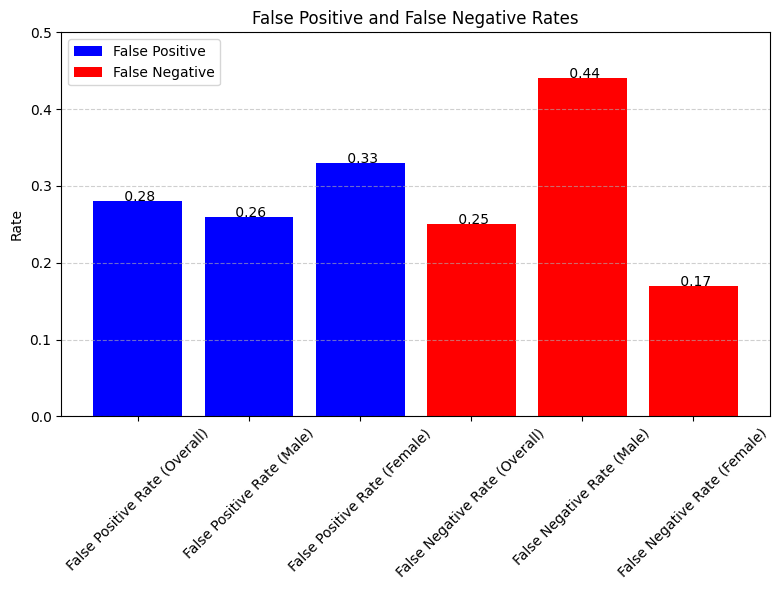

In [14]:
import matplotlib.pyplot as plt

# Data
metrics = ["False Positive Rate (Overall)", "False Positive Rate (Male)", "False Positive Rate (Female)",
           "False Negative Rate (Overall)", "False Negative Rate (Male)", "False Negative Rate (Female)"]
values = [0.28, 0.26, 0.33, 0.25, 0.44, 0.17]

colors = ['blue', 'blue', 'blue', 'red', 'red', 'red']

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=colors)
plt.ylabel('Rate')
plt.title('False Positive and False Negative Rates')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(values):
    plt.text(i, v, f' {v:.2f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()

false_positive_bar = plt.Rectangle((0, 0), 1, 1, fc="blue")
false_negative_bar = plt.Rectangle((0, 0), 1, 1, fc="red")
plt.legend([false_positive_bar, false_negative_bar], ['False Positive', 'False Negative'])

plt.show()


#### Q13 (OPTIONAL): How difficult was this homework and how many hours did you spend on it? (0 points) 

I found this homework to be fairly difficult. I had an OS test and project which I was also working on, so this project remained on the backburner for a while. That's no excuse, as my real expectation was that this project wouldnt take more than a few hours, so I delayed starting it. I know now not to do this going forward.